Autoencoders:

An autoencoder is a feed-forward neural network which takes an input X and is required to predict X. To be a bit non-trivial, a bottleneck layer is added having a dimension much lower than that of the input vector features.

Autoencoders can be of two types: linear and nonlinear. A linear autoencoder follows a similar principle to PCA as it quantifies loss in a similar manner, and aims to learn weights. These weights map the input to a different space, with new dimensions. If it is being mapped to a lower dimension, dimensionality reduction is being done. To find the best space with the least possible reconstruction error, the PCA subspace would be used. Therefore, the optimal weights for a linear autoencoder are just the principle components.

For a nonlinear autoencoder, a layer of nonlinearity is being added (ReLU, Tanh, Sigmoid). This nonlinear layer leaves the autoencoder projecting the data on a non-linear manifold. This is also known as a nonlinear dimensionality reduction.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# Load the breast cancer disgnostic dataset
dataset = load_breast_cancer()
features = dataset.data
target = dataset.target

In [25]:
# Standardizing the data using a min-max scaler
minValue = np.min(features,axis=0)
maxValue = np.max(features,axis=0)

featuresStandardized = (features - minValue) / (maxValue - minValue)
featuresTranspose = featuresStandardized.T

**Intializing Weights:**

Prevents issues with gradients such as exploding/vanishing gradients (i.e gradient either approximates to infinity or diminishes to zero).

**Vanishing Gradient:**

When the input weights are small, the gradients used to update the weights become tiny. This prevents the model from learning effectively in the optimization/regularization cycle.

**Exploding Gradient:**

If the input weights are too high, the gradients grow quickly, leaving the model unusable.

To avoid such errors, methods of weight intialization such as Xavier or the He intialization can be used.

**Xavier(Glorot)**

Works best with activation functions such as **tanh** or **sigmoid**. It balances the weights in a way that allows each layer in the network to receive data with similar variance. This helps achieve stable gradients.

**He**

Better suited for layers that utilize the **ReLU (Rectified Linear Unit)** activation function. It works as to slightly increase the variance of weights to accomodate the ReLU activation function. This is to ensure that there would be no dead neurons (i.e. neurons that do not activate).

In [17]:
# Creating the autoencoder class
class Autoencoder():
  def __init__(self, layers=[30,20,15,5,2,5,15,20,30], activationFunctions = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid'], L2 = 0.0):
    self.layers = layers
    self.activationFunctions = activationFunctions
    self.L2 = L2
    self.gradients = {}
    self.parameters = {}
    self.cache = {}

    self.initializeParameters()

  def initializeParameters(self):
    np.random.seed(1)

    length = len(self.layers) - 1
    for i in range(1, length+1):
      layerInput = self.layers[i-1]
      layerOutput = self.layers[i]
      activationFunction = self.activationFunctions[i-1]

      # Intialization will vary
      # If the activation function is ReLU --> He intialization
      # Else if ['sigmoid', 'tanh'] --> Xavier
      # Else if linear, provide a simple, smaller scale

      if activationFunction == 'relu':
        layerScale = np.sqrt(2/layerInput)
      elif activationFunction in ['sigmoid', 'tanh']:
        layerScale = np.sqrt(2/(layerInput+layerOutput))
      else:
        layerScale = 0.01

      self.parameters['Weight'+str(i)] = np.random.randn(layerOutput, layerInput) * layerScale
      self.parameters['Bias'+str(i)] = np.zeros((layerOutput, 1))

    # Make methods for all activation functions (for the forward pass)
    # And derviatives for them for the backward pass

  def relu(self, z):
    return np.maximum(0,z)

  def tanh(self, z):
    return np.tanh(z)

  def sigmoid(self, z):
    return 1/(1+np.exp(-z))

  def linear(self, z):
    return z

  def reluDerivative(self, A):
    return (A > 0).astype(float)

  def tanhDerivative(self, A):
    return 1 - np.power(A, 2)

  def sigmoidDerivative(self, A):
    return A * (1-A)

  def linearDerivative(self, A):
    return np.ones(A.shape)


  def forwardPass(self, input):
    self.cache['Activation0'] = input
    length = len(self.layers) - 1

    afterActivation = input
    for i in range(1, length+1):
      weight = self.parameters['Weight'+str(i)]
      bias = self.parameters['Bias'+str(i)]

      Z = np.dot(weight, afterActivation) + bias
      self.cache['Z'+str(i)] = Z

      activationFunction = self.activationFunctions[i-1]
      if activationFunction == 'relu':
        afterActivation = self.relu(Z)
      elif activationFunction == 'tanh':
        afterActivation = self.tanh(Z)
      elif activationFunction == 'sigmoid':
        afterActivation = self.sigmoid(Z)
      elif activationFunction == 'linear':
        afterActivation = self.linear(Z)

      self.cache['Activation'+str(i)] = afterActivation

    return afterActivation


  def lossFunction(self, outputH, output):
    # Quantify loss using Mean Squared Error (MSE)
    cost = (1.0/(2*output.shape[1])) * np.sum((outputH-output)**2)

    # L2 Regularization

    if self.L2 > 0:
      length = len(self.layers) - 1
      sum = 0
      for i in range(1, length+1):
        sum += np.sum(np.square(self.parameters['Weight'+str(i)]))
        cost += (self.L2/(2*output.shape[1])) * sum

    return cost


  def backPropagation(self,output):
    # Compute all graidents for all layers

    length = len(self.layers) - 1
    dimensions = output.shape[1]
    outputH = self.cache['Activation'+str(length)]

    # Given that MSE was used for quantifying the loss:

    if self.activationFunctions[length-1] == 'linear':
      dZ = outputH - output
    elif self.activationFunctions[length-1] == 'sigmoid':
      dZ = (outputH - output)*self.sigmoidDerivative(outputH)
    elif self.activationFunctions[length-1] == 'tanh':
      dZ = (outputH - output)*self.tanhDerivative(outputH)
    elif self.activationFunctions[length-1] == 'relu':
      dZ = (outputH - output)*self.reluDerivative(outputH)

    self.gradients['dZ'+str(length)] = dZ


     # Back propagation:

    for i in range(length, 0, -1):
      # Obtain all responsible paramters for obtained output
      dZ = self.gradients['dZ'+str(i)]
      activation = self.cache['Activation'+str(i-1)]
      weight = self.parameters['Weight'+str(i)]

      # Calculate weight and bias graidents and include L2 regularization term
      self.gradients['dW'+str(i)] = (1.0/dimensions) * np.dot(dZ, activation.T)+(self.L2/dimensions)*weight
      # keepdims --> important for retaining the original shape of the bias matrix after the derivative
      self.gradients['dB'+str(i)] = (1.0/dimensions) * np.sum(dZ, axis=1, keepdims=True)

      # Error for both current and previous layers
      if i > 1:
        currentWeight = self.parameters['Weight'+str(i)]
        activationCurrent = self.cache['Activation'+str(i-1)]
        activationFunctionName = self.activationFunctions[i-2]
        dZ = np.dot(weight.T, dZ)

        if activationFunctionName == 'relu':
          dZ = dZ * self.reluDerivative(activationCurrent)
        elif activationFunctionName == 'tanh':
          dZ = dZ * self.tanhDerivative(activationCurrent)
        elif activationFunctionName == 'sigmoid':
          dZ = dZ * self.sigmoidDerivative(activationCurrent)
        elif activationFunctionName == 'linear':
          dZ = dZ

        self.gradients['dZ'+str(i-1)] = dZ

  def step(self, learningRate):
    length = len(self.layers) - 1
    for i in range(1, length+1):
      self.parameters['Weight'+str(i)] -= learningRate * self.gradients['dW'+str(i)]
      self.parameters['Bias'+str(i)] -= learningRate * self.gradients['dB'+str(i)]

  def fit(self, inputs, epochs=100, batchSize=64, learningRate=0.001, LRDecay=0.0, scale=50):
    dimensions = inputs.shape[1]
    cost = []

    for i in range(epochs):
      # Implementing a LR scheduling policy using the LRDecay parameter
      passLR = learningRate*(1.0/(1.0+LRDecay*i))

      epochLoss = 0
      numberOfBatches = 0
      # Mini batch training

      for j in range(0, dimensions, batchSize):
        inputBatch = inputs[:, j:j+batchSize]
        output = self.forwardPass(inputBatch)
        self.backPropagation(inputBatch)
        self.step(passLR)

        batchLoss = self.lossFunction(output,inputBatch)
        epochLoss += batchLoss
        numberOfBatches += 1

      lossPerEpoch = epochLoss/numberOfBatches

      if i%scale == 0:
        print(f"Epoch #{i}: Average Loss: {lossPerEpoch:.5f}")
        cost.append(lossPerEpoch)
    return cost

  def plot(self, cost):
    plt.plot(cost)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.grid(True)
    plt.show()

In [28]:
layers=[30,25,20,15,10,15,20,25,30]
activationFunctions = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid']
L2 = 0.0001
classInstance = Autoencoder(layers=layers,activationFunctions=activationFunctions,L2=L2)

loss = classInstance.fit(featuresTranspose, epochs=1000, batchSize=64, learningRate=0.001, LRDecay=0.001,scale=100)

Epoch #0: Average Loss: 1.46573
Epoch #100: Average Loss: 0.93158
Epoch #200: Average Loss: 0.41312
Epoch #300: Average Loss: 0.32067
Epoch #400: Average Loss: 0.26336
Epoch #500: Average Loss: 0.22315
Epoch #600: Average Loss: 0.21282
Epoch #700: Average Loss: 0.20923
Epoch #800: Average Loss: 0.20688
Epoch #900: Average Loss: 0.20504


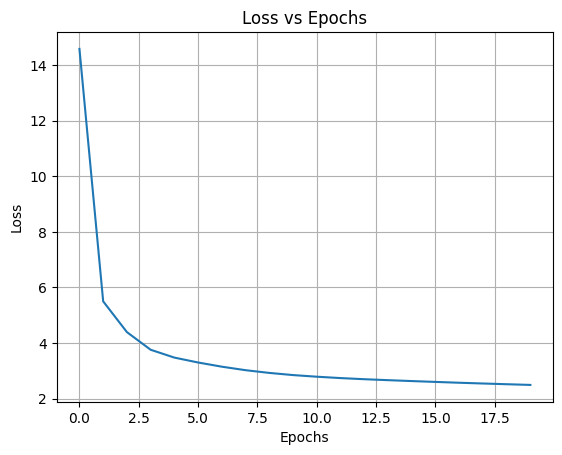

In [24]:
# Plotting the loss curve:

classInstance.plot(loss)